# Introduction
ABCGAN (atmospheric background characterization 'GAN') is a generative adversarial network that reproduces realistic physical profiles of the upper atmosphere and ionosphere.  Unlike traditional empirical models, ABCGAN can produce not only the average profile under particular conditions, but also the expected distribution of parameters.  This allows the GAN to estimate the probability that a given profile is part of the historical distribution, enabling it to determine if an event is hightly unusualy (outside the range of "normal" atmospheric variation).

The model was trained on historical measurements collected from the Poker Flat Incoherent Scattering Radar (PFISR) from 2007-2020.  PFISR measures profiles of the scalar plasma parameters electron density (Ne), electron temperature (Te), and ion temperature (Ti) in the ionosphere.  For more information about the training data, visit amisr.com.

ABCGAN is valid for predicting average ionospheric parameters over Poker Flat, AK.  The results should also be reasonable for most locations in the auroral zone, but caution should be excercied using the GAN results in other latitude regiems.

# Summary

This file provides a demonstration of the abcgan project. This includes using the Generator to generate data consistent
with the historically observed distribution and using the discriminator to detect whether measurements are consistent
with the historically observed distribution.

## Imports

Several imports are used. In particular we load `numpy`, which provides the formats for data input output.
We also use the numpy library for calculation of statistics and simulating fake data. We load `abcgan` which
has both the generator and the discriminator that we will use. Finally we load `matplotlib.pyplot`, `seaborn`,
and `pandas` for display.

In [1]:
import numpy as np  # numerics
import abcgan  # abcgan package
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # plotting
import pandas as pd  # plotting
import h5py  # reading hdf5 files

## Drivers

** Replace with or link to drivers notebook? **

We need to first get the driving parameters. We first load a set of relevant drivers that are stored in hdf5 format.
 We print the keys to show the saved list of drivers. We then convert to a standard python dictionary from hdf5 format
  then use `abcgan.stack_drivers` to aggregate the drivers for input to the generator. For this demo we will only be
  using the first 500 samples to simplify things.

In [2]:
with h5py.File('tutorial_v7.h5', 'r') as hf:
    driver_dict = hf['Drivers']
    print(list(driver_dict.keys()))
    driver_dict = {k: v[()] for k, v in driver_dict.items()}
    drivers = abcgan.stack_drivers(driver_dict)[:500, :]


['Ap', 'F10.7', 'F10.7avg', 'MLT', 'SLT', 'SZA', 'ap']


The list of drivers keys printed above corresponds to the following physical parameters:

| Key        | Full Name                      | Description                                                                 |
| ---------- | ------------------------------ | --------------------------------------------------------------------------- | 
| ap         | ap Geomagnetic Index           | Three hour equivilent planetary amplitude                                   |
| Ap         | Daily Ap Index                 | Daily equivalent planetary aplitude                                         |
| SLT        | Solar Local Time               | Local time as determined by the sun's position                              |
| MLT        | Magnetic Local Time            | Local time calculated used magnetic coordinate system                       |
| SZA        | Solar Zenith Angle             | Angle between the sun and local zenith                                      |
| ShadHeight | Shadow Height                  | Height of the Earth's shadow in the atmosphere                              |
| F10.7      | F10.7 Solar Radio Flux         | Solar rado flux at 10.7 cm (2800 MHz) in s.f.u (10^-22 W m^-2 Hz^-1)        |
| F10.7a     | Average F10.7 Solar Radio Flux | Average solar rado flux at 10.7 cm (2800 MHz) in s.f.u (10^-22 W m^-2 Hz^-1)|



Each driver is stored as a seprate vector in `tutorial_v7.h5`, where each entry in the vector is a separate sample.
So the full set of drivers for the first sample consists of the first element in each vector. The stacking routine
`abcgan.stack_drivers` collates these into a single data structure which has size nSamples x nDrivers, in the order
specificed by `abcgan.driver_names`. `abcgan.stack_drivers` can accept either an `h5py.Group` object directly or
as shown above a dictionary mapping each driver name to a one dimensional numpy array.

See the tutorial on generating and saving drivers in this directory for how to create a driver file.

## Altitudes
The ABC GAN predicts background values on a set, non-uniform altitude grid.  The non-uniform grid was chosen to be higher resolution in the lower atmosphere where important dynamics occur at smaller scales, but lower resolution at high altitudes where the atmosphere is more stable across a larger range and data is sparser.

| Altitude Range | Grid Spacing |
|----------------|--------------|
| 90 - 120 km    | 4.5 km       |
| 120 - 150 km   | 9 km         |
| 150 - 200 km   | 18 km        |
| 200 - 800 km   | 24 km        |


In [3]:
altgrid = np.concatenate((np.arange(92.,119.,4.5),np.arange(119.,146.,9.),np.arange(146.,200.,18.),np.arange(200.,800.,24.)))    # altitude grid

## Generate

Given the driving parameters we can now generate a set of measurements, one for each sample.

The output is an array of measurements, one for each altitude bin, for each driver. In this case there are 500 different sets of driving parameters. We choose to generate 30 altitude bins worth of data (which is both the default and the maximum as specified in `abcgan.max_alt`). There are six background variables generated for each sample for each altitude bin.

In [4]:
meas = abcgan.generate(drivers, n_alt=30)
print(meas.shape)
print(abcgan.bv_names)

(500, 30, 6)
['Ne_bac', 'Ne_rms', 'Te_bac', 'Te_rms', 'Ti_bac', 'Ti_rms']


The generated background parameters, in the order specified by `abcgan.bv_names`, are:

| Parameter | Variable Name | Units |
|-----------|---------------|-------|
| Average Electron Density | Ne_bac | m$^{-3}$ |
| Root Mean Square Variation of Electron Density | Ne_rms | m$^{-3}$ |
| Average Electron Temperature | Te_bac | K |
| Root Mean Square Variation of Electron Temperature | Te_rms | K |
| Average Ion Temperature | Ti_bac | K |
| Root Mean Square Variation of Ion Temperature | Ti_rms | K |


Averages and root mean square values are over the standard smoothing window of .5 hours.

## Sampling

To generate multiple samples for the same driving parameters (usually in order to compute statistics) pass a repeated version of the drivers. Each output will be a separate sample. Here we generate 50 samples using the first set of saved drivers.

In [5]:
meas_sampled = abcgan.generate(drivers[:1, :].repeat(50, 0))
print(meas_sampled.shape)

(50, 30, 6)


## Load Background Variables

We can now load a sample of background variable observations collected at the same time as each of the sampled drivers above from the same `tutorial_v7.h5` file. The `tutorial_v7.h5` file contains about 5000 samples, but for this demo we will only be using the first 500 samples to simplify things. Note that here we directly stack the backround varibales using `abcgan.stack_bvs` from the `h5py.Group`. In the hdf5 file each background variable is saved as a single array of size nSamples x nAltitude, where missing values are padded with nans. Note that the first dimensions (number of samples) is 500, corresponding to the 500 sets of drivers. The final dimension is 6 corresponding to the number of background variables.

In [6]:
with h5py.File('tutorial_v7.h5', 'r') as hf:
    bvs = abcgan.stack_bvs(hf['BackgroundVariables'])[:500, :, :]
    print(bvs.shape)

(500, 37, 6)


## Compare Generated Profile
As a practical example, look at several real profiles of electron density from the background values data with similar driving conditions and compare them to the set of profiles generated by the GAN for these drivers.  First identify points from the sample data set that were close to noon MLT with Ap<5 and F10.7<80.  Then find the average driving conditions for these points and use them to generate sampled profiles with the GAN.

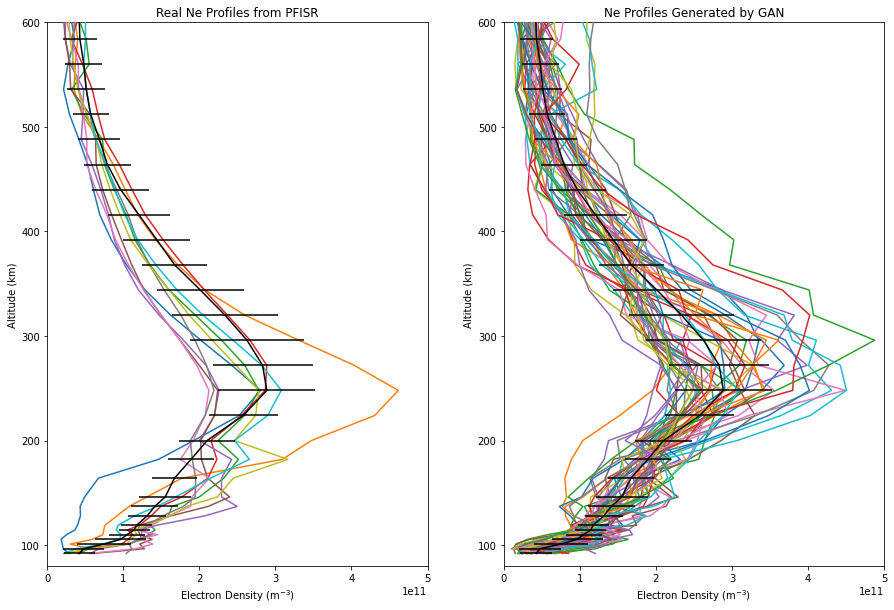

In [7]:
idx = np.argwhere((np.abs(drivers[:,3]-12.)<1.) & (drivers[:,0]<5.) & (drivers[:,1]<80.)).flatten()
avg_drivers = np.mean(drivers[idx,:], axis=0)[None,:]

gen_profiles = abcgan.generate(avg_drivers.repeat(50, 0))
mean_profile = np.mean(gen_profiles, axis=0)
std_profile = np.std(gen_profiles, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].plot(bvs[idx,:,0].T, altgrid, zorder=3)
ax[0].set_title('Real Ne Profiles from PFISR')

ax[1].plot(gen_profiles[:,:,0].T, altgrid[:30], zorder=3)
ax[1].set_title('Ne Profiles Generated by GAN')

for i in range(2):
    ax[i].errorbar(mean_profile[:,0], altgrid[:30], xerr=std_profile[:,0], color='black', zorder=5)
    ax[i].set_xlim([0.,5.e11])
    ax[i].set_ylim([80.,600.])
    ax[i].set_xlabel(r'Electron Density (m$^{-3}$)')
    ax[i].set_ylabel('Altitude (km)')
    
plt.show()

The black profile in both plots is the mean and standard deviation of the sampled profiles from the GAN.  They agree with the measured profiles, and contain information about the expected spread of the electron density at each altitude.

The output of the GAN is **statistical**, and each individual generated profile is a sampled profile from the distribution but does not nessisarily represent the "average" or "typical" conditions.

## Scoring 

To score the background variables we run the critic providing both the drivers and the measurements. Each altitude
is scored separately, correspoinding to how well the measurements at that altitude fit the historically observed
distribution, conditional upon both the drivers and all lower altitude measurements. To score the entire mesurement
set overall we sum the contributions from all altitude bins.

In [8]:
bin_score = abcgan.discriminate(drivers, bvs)
print(bin_score.shape)
total_score = bin_score.sum(-1)
print(total_score.shape)

(500, 30)
(500,)


To score only the first ten bins we can just provide the first 10 data points.

In [9]:
bin_score = abcgan.discriminate(drivers, bvs[:, :10, :])
print(bin_score.shape)
total_score = bin_score.sum(-1)
print(total_score.shape)

(500, 10)
(500,)


We can directly compare the average scores of the real data versus obviously fake data.

In [10]:
mean_good = abcgan.discriminate(drivers, bvs).mean()
mean_bad = abcgan.discriminate(drivers, np.ones(bvs.shape)).mean()
print(f'good: {mean_good}')
print(f'bad: {mean_bad}')

good: 3.2801079750061035
bad: 11.800446510314941


## Exploring the results

The above utilities are still being tested and developed. We expect to soon have the following included in the tutorial:
- Demonstration showing how to compare the histograms of generated data with historically observed data.
- Demonstrate how to use the discriminator score to distinguish real and fake data, including improved calibration.

Select an altitude bin, say the 25th, to compare histograms and filter out any possible outliers in the data using `valid_mask` created from `transforms.scale(bvs)` function.

In [11]:
alt_bin = 20
_, valid_mask = abcgan.transforms.scale_bv(bvs)
real = bvs[valid_mask, alt_bin, :]
generated = meas[valid_mask, alt_bin, :]

We can then compare the distributions of the `real` and `generate` values for each of the
6 background variables using a kde plot implemented with matplotlib and seaborn. The nested for loop iterates over each of the 6 distubtions plots we want make. One is added to the `real` and `gernerated` values to avoid log scaling values less than or equal to zero

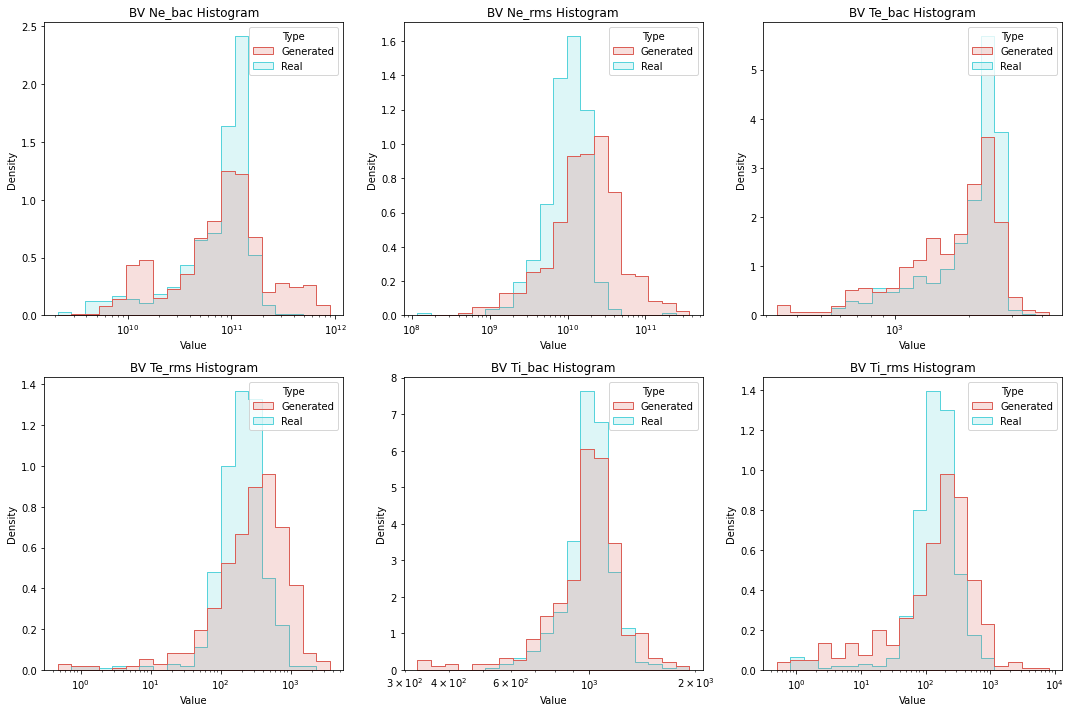

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    for j in range(3):
        var1 = 1 + real[..., 3*i + j].flatten()
        var2 = 1 + generated[..., 3*i + j].flatten()
        x = np.hstack((var1, var2))
        hue = ['Real'] * len(var1) + ['Generated'] * len(var2)
        data = pd.DataFrame({'Value': x, 'Type': hue})
        sns.histplot(data=data, x='Value', hue='Type', ax=ax[i, j],
                     element='step', bins=20, legend=True, stat='density',
                     palette='hls', alpha=0.2, common_norm=False,
                     hue_order=['Generated', 'Real'], log_scale=True)
        ax[i, j].set_title(f'BV {abcgan.constants.bv_names[3*i + j]} Histogram')
plt.tight_layout()
plt.show()